# Project 4: Logistic Regression & Best Predictor of Data Science Salary Bin
By Byron Allen

##### Description

I scrapped key data points from over 2700 jobs across six cities: Sydney, Melbourne, San Francisco, New York, Newark and Chicago. The resulting datasets were collated, cleaned and stored in the pandas DataFrame 'jobs', which was used to identify what feature is the best predictor of salary. 

The results of the logistic regression indicate that there are few features acting as valid predictors. Specifically, words from job titles or job descriptions are the most accurate predictors, but only for the lowest salary bin. 

##### Contents

* Import scrapped data
* Further clean data
* Convert salaries into USD
* Explore shape of dataset
* Select optimal bins for salaries
* Create CVSvDummy function to print results
* Logistical Regression and results
* Key words (from job titles) associated with salary
* Key words (from job descriptions) associated with salary


In [1]:
%matplotlib inline
import requests
import urllib2
import bs4
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import psycopg2
import string

In [2]:
jobs = pd.read_csv('.no_get/job_searches.csv')
nyc_jobs = pd.read_csv('.no_get/new_job_searches.csv')
chi_jobs = pd.read_csv('.no_get/chi_job_searches.csv')

In [3]:
print jobs.shape
print nyc_jobs.shape

(1326, 16)
(1078, 16)


In [4]:
jobs = jobs.append(nyc_jobs)
jobs = jobs.append(chi_jobs)

In [5]:
jobs.shape

(2713, 16)

In [6]:
print jobs.shape
jobs.drop(labels=['salary_bins', 'salary', 'job_posted'], axis=1, inplace=True)
jobs.info()

(2713, 16)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2713 entries, 0 to 308
Data columns (total 13 columns):
company                 2713 non-null object
culture                 2713 non-null object
job_addr                2713 non-null object
job_description         2713 non-null object
job_security_advance    2713 non-null object
job_title               2713 non-null object
link                    2713 non-null object
management              2713 non-null object
reviews_score           2713 non-null float64
reviews_total           2713 non-null object
salary_benefits         2713 non-null object
work_life_bal           2713 non-null object
salary_bins_int         2713 non-null int64
dtypes: float64(1), int64(1), object(11)
memory usage: 296.7+ KB


In [7]:
states=[]

for i in jobs.job_addr:
    if 'CA' in i:
        states.append('CA')
    elif 'NSW' in i:
        states.append('NSW')
    elif 'VIC' in i:
        states.append('VIC')
    elif 'NY' in i:
        states.append('NY')
    elif 'NJ' in i:
        states.append('NJ')
    elif 'IL' in i:
        states.append('IL')
    else:
        states.append('i')
        
jobs['state'] = states

jobs.state.unique()

array(['NSW', 'VIC', 'CA', 'NY', 'NJ', 'IL'], dtype=object)

### Convert to USD

In [8]:
dictionary={'NSW': 0.77, 'VIC': 0.77, 'CA': 1, 'NY': 1, 'NJ': 1, 'IL': 1}
jobs['conversion_to_USD'] = jobs.state.map(dictionary) 
jobs['adj_salary_bin'] = jobs.salary_bins_int*jobs.conversion_to_USD

### Exploratory Analysis

In [9]:
import matplotlib.pyplot as plt

In [10]:
sb.distplot?

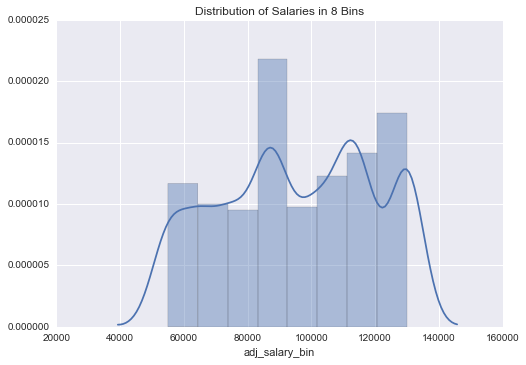

In [11]:
sb.distplot(jobs.adj_salary_bin, bins=8, kde=True)
plt.title('Distribution of Salaries in 8 Bins')

plt.show()

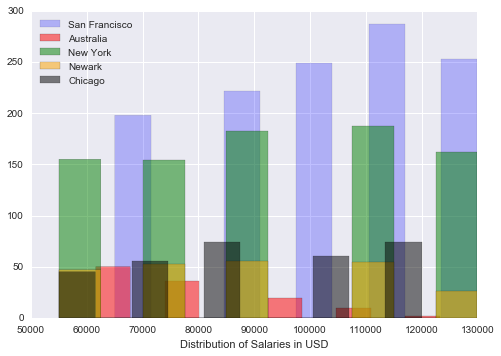

In [25]:
cali = jobs[jobs.state == 'CA']
#nyc = jobs[(jobs.state == 'NY' )& (jobs.state == 'NJ')]
ny = jobs[jobs.state == 'NY']
nj = jobs[jobs.state == 'NJ']
il = jobs[jobs.state == 'IL']
aus = jobs[jobs.conversion_to_USD == 0.77]

plt.hist(cali.adj_salary_bin, color='b', alpha=0.25)
plt.hist(aus.adj_salary_bin, color='r', alpha=0.5)
plt.hist(ny.adj_salary_bin, color='g', alpha=0.5)
plt.hist(nj.adj_salary_bin, color='orange', alpha=0.5)
plt.hist(il.adj_salary_bin, color='black', alpha=0.5)


plt.xlabel('Distribution of Salaries in USD')
plt.legend(['San Francisco', 'Australia', 'New York', 'Newark', 'Chicago'], loc=2)

plt.show()

In [21]:
plt.legend?

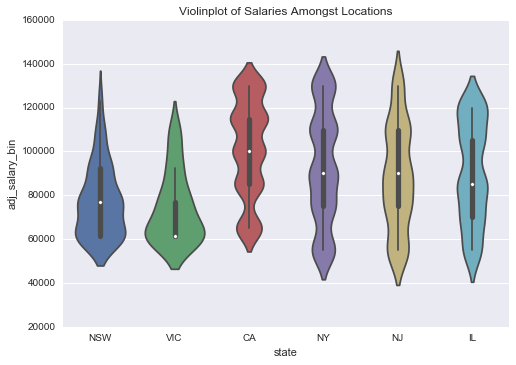

In [13]:
import seaborn as sb
sb.violinplot(x=jobs.state, y=jobs.adj_salary_bin, data=jobs)
plt.title('Violinplot of Salaries Amongst Locations')
plt.show()

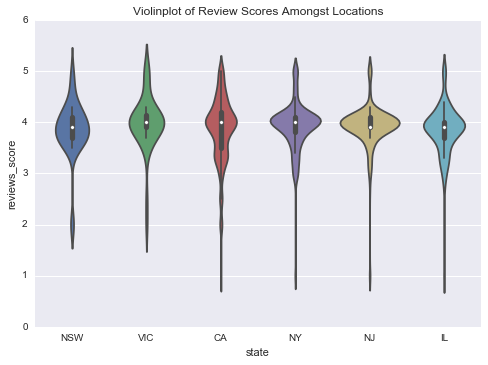

In [14]:
sb.violinplot(x=jobs.state, y=jobs.reviews_score, data=jobs)
plt.title('Violinplot of Review Scores Amongst Locations')
plt.show()

### Binning

In [15]:
jobs['sal_bins'] = pd.cut(jobs.adj_salary_bin, 8, labels=[1,2,3,4,5,6,7,8])

dictionary = {'NSW':0, 'VIC':1, 'CA':2, 'NY':3, 'NJ':4, 'IL':5}
jobs['state_number'] = jobs.state.map(dictionary)

In [16]:
jobs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2713 entries, 0 to 308
Data columns (total 18 columns):
company                 2713 non-null object
culture                 2713 non-null object
job_addr                2713 non-null object
job_description         2713 non-null object
job_security_advance    2713 non-null object
job_title               2713 non-null object
link                    2713 non-null object
management              2713 non-null object
reviews_score           2713 non-null float64
reviews_total           2713 non-null object
salary_benefits         2713 non-null object
work_life_bal           2713 non-null object
salary_bins_int         2713 non-null int64
state                   2713 non-null object
conversion_to_USD       2713 non-null float64
adj_salary_bin          2713 non-null float64
sal_bins                2713 non-null category
state_number            2713 non-null int64
dtypes: category(1), float64(3), int64(2), object(12)
memory usage: 384.2+ KB


### CVSvDummy Function 

In [17]:
def CVSvDummy(model, X, y):
    print '================================='
    #print 'Model: ', model
    print
    scoring = cross_val_score(model,X,y,cv=5,scoring='accuracy')
    print 'CV Score: ', scoring.mean()
    print

    dum_score = cross_val_score(DummyClassifier(strategy='most_frequent'),X,y,cv=5,scoring='accuracy')
    print 'Dummy Score: ', dum_score.mean()
    print
    print
    
    print 'Salary & Coefs:'
    lr.fit(X,y)
    for x in zip(jobs.sal_bins.unique(),model.coef_):
        print x
    
    print

### Logistic Regression

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, classification_report
lr = LogisticRegression()

In [19]:
tfidf = TfidfVectorizer()
key_words = tfidf.fit_transform(jobs.job_title).toarray()

print jobs.shape
print key_words.shape

(2713, 18)
(2713, 1448)


In [20]:
print 'KEY_WORD'
X = key_words
y = jobs.sal_bins
CVSvDummy(lr, X, y)

print 'STATE'
x=jobs[['state_number']]
y=y
CVSvDummy(lr, x, y)

print 'REVIEW_SCORE'
x=jobs[['reviews_score']]
y=y
CVSvDummy(lr, x, y)

print 'COMBO'
x=jobs[['state_number', 'reviews_score', ]]
y=y
CVSvDummy(lr, x, y)


KEY_WORD

CV Score:  0.247641409127

Dummy Score:  0.20420457697


Salary & Coefs:
(1, array([-0.04609744, -0.03534747, -0.05662844, ..., -0.08540821,
       -0.06808206, -0.03446468]))
(3, array([-0.03899481, -0.03501601, -0.0253731 , ..., -0.34770245,
       -0.07690603, -0.03170895]))
(4, array([-0.0461532 , -0.03943986, -0.06734705, ..., -0.36555727,
       -0.09001154, -0.04293142]))
(6, array([-0.09703542, -0.09549489, -0.07659559, ...,  0.39239356,
       -0.16900593, -0.07886796]))
(8, array([-0.06633007, -0.0417763 , -0.03112554, ..., -0.26182536,
        0.55840173,  0.50634135]))
(2, array([-0.04421378,  0.39063751,  0.39491688, ...,  0.56737835,
       -0.04985818, -0.04965251]))
(5, array([ 0.4292425 , -0.05198144, -0.04096319, ..., -0.36733438,
       -0.05782429, -0.06923292]))
(7, array([-0.05141582, -0.05928845, -0.06761169, ...,  0.23832962,
       -0.03209589, -0.14090564]))

STATE

CV Score:  0.176559304539

Dummy Score:  0.20420457697


Salary & Coefs:
(1, array([ 

### Narrow the scope: Focus on salary bin 1

In [21]:
jobs_low = jobs[jobs.sal_bins <= 2]

tfidf = TfidfVectorizer()
key_words_low = tfidf.fit_transform(jobs_low.job_title).toarray()

print jobs_low.shape
print key_words_low.shape

print 'KEY_WORD'
X = key_words_low
y = jobs_low.sal_bins
CVSvDummy(lr, X, y)

print 'STATE'
x=jobs_low[['state_number']]
y=y
CVSvDummy(lr, x, y)

print 'REVIEW_SCORE'
x=jobs_low[['reviews_score']]
y=y
CVSvDummy(lr, x, y)

print 'COMBO: STATE & REVIEW'
x=jobs_low[['state_number', 'reviews_score', ]]
y=y
CVSvDummy(lr, x, y)


(551, 18)
(551, 600)
KEY_WORD

CV Score:  0.635104629233

Dummy Score:  0.539018551496


Salary & Coefs:
(1, array([-0.12431381, -0.18579361,  0.41891134, -0.15362254, -0.11988349,
        0.18278723, -0.18080447, -0.24221321, -0.24209299,  0.62393514,
       -0.09786161,  0.89613586, -0.36646341, -0.26306965, -0.28916767,
        0.24199367,  0.34442398, -0.30674641, -0.16119114,  0.04975248,
       -0.32777567, -0.01258472,  0.06426546,  0.2523161 , -0.15605856,
       -0.04682436, -0.17680197,  0.440985  , -0.12431381,  0.43428848,
        0.29229824, -0.1548334 ,  0.50916022, -0.93224917,  0.32061398,
        0.57110289, -0.37041462, -0.23850672,  0.41726738, -0.36889885,
       -0.17900171,  0.354434  , -0.16033015,  0.31523469,  0.23078054,
       -0.11593092,  0.38459274, -0.1209049 ,  0.42558136, -0.14988214,
       -0.12997657, -0.01605283, -0.18125383,  0.07820405,  0.69187527,
        0.23078054,  0.23078054, -0.1781952 ,  0.17340255,  0.27860156,
        0.21598892,  0.9925

#### Key words appears to be the strongest indicator of salary

In [22]:
lr = LogisticRegression(class_weight='balanced')
x=key_words_low

#Train-Test Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

lr.fit(x_train,y_train)
y_pred = lr.predict(x_test)

cm = confusion_matrix(y_test,y_pred)
cr = classification_report(y_test, y_pred, digits=4)

print 'Confusion Matrix'
print cm
print

print 'Classification Report:'
print cr
print 

Confusion Matrix
[[63 23]
 [36 60]]

Classification Report:
             precision    recall  f1-score   support

          1     0.6364    0.7326    0.6811        86
          2     0.7229    0.6250    0.6704        96

avg / total     0.6820    0.6758    0.6754       182




#### The default Logistic Regression parameters are the be best after conducting a GridSearchCV

In [23]:
from sklearn.grid_search import GridSearchCV

In [24]:
params = {'C':[0.5, 1, 1.5, 2]}

search = GridSearchCV(lr,params)
search

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.5, 1, 1.5, 2]}, pre_dispatch='2*n_jobs',
       refit=True, scoring=None, verbose=0)

#### Logistic Regression on  Job Description

In [25]:
tfidf = TfidfVectorizer()
key_words_job_desc = tfidf.fit_transform(jobs.job_description).toarray()

print jobs.shape
print key_words_job_desc.shape

print 'KEY_WORD_JOB_DESC'
X = key_words_job_desc
y = jobs.sal_bins
CVSvDummy(lr, X, y)

(2713, 18)
(2713, 4428)
KEY_WORD_JOB_DESC

CV Score:  0.221546572964

Dummy Score:  0.20420457697


Salary & Coefs:
(1, array([ 0.09633122,  0.01703271,  0.07406928, ..., -0.01802644,
       -0.09989672, -0.11013773]))
(3, array([-0.40080744, -0.33831634, -0.08858698, ..., -0.01687739,
       -0.07054719, -0.1926451 ]))
(4, array([-0.46810806,  0.37976689, -0.10948756, ..., -0.03048562,
       -0.04287564, -0.09915315]))
(6, array([-0.2680275 , -0.15853808,  0.02724551, ..., -0.04758801,
       -0.06959812, -0.00638549]))
(8, array([-0.32561938, -0.37104058, -0.15334346, ..., -0.06128399,
       -0.09050635,  1.03798119]))
(2, array([ 0.5193582 , -0.03606082, -0.12771159, ..., -0.04026103,
       -0.09992745, -0.14153582]))
(5, array([-0.14566215,  0.31927877,  0.00250354, ...,  0.29583363,
       -0.14340898, -0.21450077]))
(7, array([ 0.62505331,  0.19662517,  0.16305767, ..., -0.10163851,
        0.44549377, -0.18518696]))



In [26]:
key_words_job_desc = tfidf.fit_transform(jobs_low.job_description).toarray()
print 'KEY_WORD_JOB_DESC'
X = key_words_job_desc
y = jobs_low.sal_bins
CVSvDummy(lr, X, y)

KEY_WORD_JOB_DESC

CV Score:  0.637135751264

Dummy Score:  0.539018551496


Salary & Coefs:
(1, array([-0.27381866, -0.1851031 , -0.07366179, ..., -0.24311555,
        0.14971884, -0.11940071]))



## Key Words - Job Title

In [27]:
tfidf = TfidfVectorizer()
key_words = tfidf.fit_transform(jobs.job_title).toarray()

print jobs.shape
print key_words.shape

X = key_words
y = jobs.sal_bins

elastic = ElasticNetCV()
elastic.fit(X,y)

word_impact = pd.DataFrame()
word_impact['word'] = tfidf.get_feature_names()
word_impact['elasticnet_coef'] = elastic.coef_
sorted_words = word_impact.sort(columns='elasticnet_coef', ascending=False)
print sorted_words.head(15)
print sorted_words.tail(15)

(2713, 18)
(2713, 1448)
           word  elasticnet_coef
388    director         3.220899
1410         vp         2.907141
1041  principal         2.683916
1009   platform         2.609830
1050    product         2.448194
97    architect         2.238296
760        lead         2.123692
341        data         2.096103
614        head         2.032224
609      hadoop         1.984952
1226  solutions         1.956434
557    frontend         1.876836
1222   software         1.823754
135         avp         1.705201
1052   products         1.693194
                 word  elasticnet_coef
510               fgp        -1.517902
115         associate        -1.553633
506            fellow        -1.626073
1281       supervisor        -1.626450
191   biostatistician        -1.717757
458     environmental        -1.755988
724                it        -1.823963
1284          support        -1.877146
1234       specialist        -1.991426
1023     postdoctoral        -2.199271
74            analy

/Users/allenbyron/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


## Key Words - Job Description

In [28]:
tfidf = TfidfVectorizer()
key_words = tfidf.fit_transform(jobs.job_description).toarray()

print jobs.shape
print key_words.shape

X = key_words
y = jobs.sal_bins

elastic = ElasticNetCV()
elastic.fit(X,y)

word_impact = pd.DataFrame()
word_impact['word'] = tfidf.get_feature_names()
word_impact['elasticnet_coef'] = elastic.coef_
sorted_words = word_impact.sort(columns='elasticnet_coef', ascending=False)
print sorted_words.head(15)
print sorted_words.tail(15)

(2713, 18)
(2713, 4428)
            word  elasticnet_coef
1033        data         3.926169
3559  scientists         3.008703
475          big         2.849147
3057    platform         2.360463
3554     science         2.335879
2010   implement         1.955046
3176     product         1.834529
1866       hands         1.794240
564        build         1.776105
2319        lead         1.772007
468         best         1.710472
4085         top         1.692846
567     building         1.622576
1171    director         1.580197
3542       scale         1.541589
               word  elasticnet_coef
1401  environmental        -1.081689
3859    strategists        -1.086894
244         analyst        -1.107337
535            both        -1.152908
3123        prepare        -1.157570
760      collection        -1.298922
3455        results        -1.301222
2176      interpret        -1.315410
1937       hospital        -1.351071
1895         health        -1.351496
252        analyzes      

/Users/allenbyron/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


## Possible Next Steps 

* **Use Other Models:** Lasso, Ridge, GridSearchCV
* **Try Predicting:** Build function to test job titles
* **Try Reshapping Data:** There are alternate dataset shapes available 